# RANS-CVA

Stands for Reynolds Average Navier Stokes - Coherent Vortex Agent

## Objective
To recover the mixing induced by vortices in low Reynolds number flows

## Equations

### RANS Lagrangian particles

The transport of tracers and point-eddies is Lagrangian. In pure RANS, acceleration typically contains a Brownian term to model turbulent diffusion:
$$
\frac{d\mathbf{u}'_p}{dt}=W(t)\sqrt{\frac{2k(\mathbf{x}_p)}{3}}\mathbf{e}
$$
where $W(t)$ is a Brownian term, $\mathbf{e}$ the unit vector and $k$ the local turbulent kinetic energy of the flow. The drag force is not considered here, as the particles of interest are considered passive, or inertialess particles. Lagrangian tracking consists of the  integration of the above equation and the below equation: 

$$
\frac{d\mathbf{x}_p}{dt} = \overline{\mathbf{u}}(\mathbf{x}_p)+\mathbf{u}'_p(\mathbf{x}_p,t)
$$
The first velocity on the RHS is the RANS mean velocity vector.

### RANS-Coherent Vortex Lagrangian particles

We propose to control the dispersion of tracers using point-eddies (in 2D)

$$
\frac{d\mathbf{x}_p}{dt} = \overline{\mathbf{u}}(\mathbf{x}_p)+\widetilde{\mathbf{u}}(\mathbf{x}_p,t)
$$

The new term on the RHS is the induced velocity vector generated by the presence of a number $\N_{e}$ of point-eddies of circulation $\Gamma_j$ and radius $\sigma_j$:
$$
\widetilde{\mathbf{u}}(\mathbf{x},t)=\sum_{j=1}^{N_e}\Gamma_j\mathbf{K}_\sigma(\mathbf{x}-\mathbf{x}_j)
$$
with the eddy kernel:
$$
\mathbf{K}_\sigma(r)=\frac{1}{2\pi r^2}\left(1-\exp\left(-\frac{r^2}{\sigma^2}\right)\right)\left[-r_y,r_x\right]
$$

The variables are:
* Injection location and timing of point-eddies
* Circulation and radius of individual point-eddies and their possible evolution in time.


In [137]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
dims = 2
trdims = 4
eddims = 7
i_x = 0; i_y = 1; i_u = 2; i_v = 3; i_G = 4; i_s = 5; i_t = 6


dt = 0.1
Lx = 50.
Ly = 20.
yc = np.linspace(-Ly/2,Ly/2,1001)
Umean = 1 - 0.2*np.exp(-(yc/1.)**2)
V_mean = 0.0
from scipy.interpolate import interp1d
f_Umean = interp1d(yc,Umean)
Ly_inj = 19.
Npt_inj = 50
y_inj = np.linspace(-Ly_inj/2,Ly_inj/2,Npt_inj)
x_inj = np.zeros(Npt_inj)
tracers_inj = np.zeros((Npt_inj,trdims),dtype='float64')
tracers_inj[:,i_y] = y_inj
tracers_inj[:,i_u] = f_Umean(tracers_inj[:,i_y])
T_tracer_inj = 0.25
it_inj = int(T_tracer_inj / dt)
T_eddies = 2.5
it_eddy_inj = int(T_eddies / dt)
x_eddy_inj = 1.0
y_eddy_inj = 0.5
Gamma_inj = 2.
sigma_inj = 1.0
eddy_inj = np.zeros((1,eddims),dtype='float64')
eddy_inj[0,i_x] = x_eddy_inj
eddy_inj[0,i_y] = y_eddy_inj
eddy_inj[0,i_u] = 0.0
eddy_inj[0,i_v] = 0.0
eddy_inj[0,i_G] = Gamma_inj
eddy_inj[0,i_s] = sigma_inj
Tsimu = 100.
Nt = int(Tsimu / dt)

i = 0
iphase = 0
ie_count = 0
while i < Nt:
    if (i == 0):
        tracers = np.copy(tracers_inj)
    elif (i % it_inj) == 0:
        tracers = np.insert(tracers,np.shape(tracers)[0],tracers_inj,axis=0)
    Ntracers = np.shape(tracers)[0]
    if (i == 0):
        ie = 0
        eddies = np.copy(eddy_inj)
        eddies[ie,i_y] *= (-1.0)**ie_count
        eddies[ie,i_u] = f_Umean(eddies[ie,i_y])
        eddies[ie,i_v] = 0.0
        eddies[ie,i_G] *= (-1.0)**(ie_count+1)
        Neddies = 1
        ie_count += 1
    elif (i % it_eddy_inj) == 0:
        eddies = np.insert(eddies,np.shape(eddies)[0],eddy_inj,axis=0)
        Neddies = np.shape(eddies)[0]
        ie = Neddies - 1
        eddies[ie,i_y] *= (-1.0)**ie_count
        eddies[ie,i_u] = f_Umean(eddies[ie,i_y])
        eddies[ie,i_v] = 0.0
        eddies[ie,i_G] *= (-1.0)**(ie_count+1)
        ie_count += 1
    Ntracers = np.shape(tracers)[0]
    # RANS velocity
    tracers[:,i_u] = f_Umean(tracers[:,i_y])
    tracers[:,i_v] = V_mean
    # Eddy-Induced velocity
    for ie in range(Neddies):
        rvec = np.zeros((Ntracers,dims),dtype='float64')
        for j in range(dims):
            rvec[:,j] = tracers[:,j] - eddies[ie,j]
        r2 = rvec[:,i_x]**2+rvec[:,i_y]**2
        mask = np.where(r2 != 0.0)
        r2inv = np.zeros_like(r2)
        r2inv[mask] = 1.0/r2[mask]
        GKs = eddies[ie,i_G]/(2*np.pi)*r2inv*(1.0 - np.exp(-r2/(2*eddies[ie,i_s]**2)))
        tracers[:,i_u] -= GKs*rvec[:,i_y]
        tracers[:,i_v] += GKs*rvec[:,i_x]
    tracers[:,i_x:i_y+1] += dt*tracers[:,i_u:i_v+1]
    # Boundary conditions
    maskx = np.where(tracers[:,i_x] > Lx)
    if (len(maskx[0]) > 0):
        tracers = np.delete(tracers,maskx[0],axis=0)
    masky = np.where(np.abs(tracers[:,i_y]) > Ly/2.)
    if (len(masky[0]) > 0):
        tracers = np.delete(tracers,masky[0],axis=0)
    eddies[:,i_u] = f_Umean(eddies[:,i_y])
    eddies[:,i_v] = V_mean
    for ie in range(Neddies):
        for ie1 in range(Neddies):
            if (ie != ie1):
                rvec = np.zeros(2,dtype='float64')
                rvec = eddies[ie,i_x:i_y+1] - eddies[ie1,i_x+i_y+1]
                r2 = np.sum(rvec**2)
                r2inv = 1.0/r2
                GKs = eddies[ie1,i_G]/(2*np.pi)*r2inv*(1.0 - np.exp(-r2/(2*eddies[ie1,i_s]**2)))
                eddies[ie,i_u] -= GKs*rvec[i_y]
                eddies[ie,i_v] += GKs*rvec[i_x]
    eddies[:,i_x:i_y+1] += dt*eddies[:,i_u:i_v+1]
    maskx = np.where(eddies[:,i_x] > Lx)
    if len(maskx[0]) > 0 :
        eddies = np.delete(eddies,maskx[0],axis=0)
    masky = np.where(np.abs(eddies[:,i_y]) > Ly/2.0)
    if len(masky[0]) > 0 :
        eddies = np.delete(eddies,masky[0],axis=0)
    Neddies = np.shape(eddies)[0]
    i += 1
#     print(i)
    if (i % it_inj) == 0:
        print(Nt,i,Ntracers,Neddies)
        clear_output(wait=True)


1000 1000 13413 20


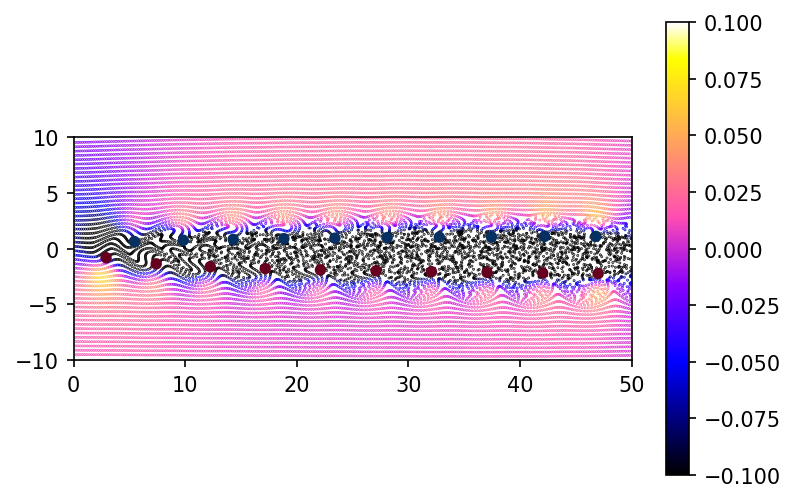

In [138]:
fig, ax = plt.subplots(dpi=150)
x = tracers[:,i_x]
y = tracers[:,i_y]
# c = np.sqrt(np.sum(tracers[:,i_u:i_v+1]**2,axis = 1))
c = tracers[:,i_u] - f_Umean(tracers[:,i_y])
scat = plt.scatter(x, y, c=c, s=0.1,cmap='gnuplot2',vmin=-0.1,vmax=0.1)
fig.colorbar(scat)
x = eddies[:,i_x]
y = eddies[:,i_y]
c = eddies[:,i_G]
plt.scatter(x,y, c=c, s=20, marker = "o",cmap='RdBu_r',vmin=-0.9*Gamma_inj,vmax=0.9*Gamma_inj)
plt.xlim(0,Lx)

plt.ylim(-Ly/2,Ly/2)
ax.set_aspect('equal')
plt.show()